# VQE


***Goal:*** Find the (lowest) upper-bound of the lowest <em>eigenvalue</em> (the <em>Ground-State</em>) of a given Hamiltonian.

$$\begin{align}
H \left|\psi\right> &= \lambda \left|\psi\right>\\
& \\
\left<\psi\right| H \left|\psi\right> &= \lambda \left<\psi\right|\left.\psi\right>\\
&\\
\frac{ \left<\psi\right| H \left|\psi\right> }{ \left<\psi\right|\left.\psi\right> } &= \lambda \equiv E_\lambda
\end{align}$$

***Algorithm***:
* 1\. Choose an Ansatz for initial $\left|\psi\right>$
* 2\. Initialize circuit with starting parameters $\vec{\theta_0}$
* 3\. For iteration in iterations
    * 3.1\. Pass $\left|\psi\right>$ through the $circuit(\vec{\theta})\,\,\to\,\,\left|\psi(\theta)\right>$
    * 3.2\. Compute $\left<\psi(\theta)\right|H\left|\psi(\theta)\right>$ (assuming normalization)
    * 3.3\. Update parameters $\theta$ to minimize $\left<\psi(\theta)\right|H\left|\psi(\theta)\right>$
    
    
<img src="https://qiskit.org/textbook/ch-applications/images/U3_var_form.png" alt="circ" width="500"> 

---

# VQE on Ising Hamiltonian
## Transverse field
---
Implement Variational Quantum Eigensolver algorithm for the system:
$$ H = \lambda \sum_{i}^{N} \sigma_z^i - \sum_{i}^{N-1} \sigma_{x}^{i+1}\sigma_x^i $$

where:
$$
\begin{align}
\sigma_z^i &= \mathbb{I}\otimes\mathbb{I}\otimes ... \otimes \mathbb{I}\otimes \begin{pmatrix}1 & 0 \\ 0 & -1 \end{pmatrix} \otimes \mathbb{I}\otimes ... \otimes \mathbb{I} \\
\sigma_x^i &= \mathbb{I}\otimes\mathbb{I}\otimes ... \otimes \mathbb{I}\otimes \begin{pmatrix}0 & 1 \\ 1 & 0 \end{pmatrix} \otimes \mathbb{I}\otimes ... \otimes \mathbb{I} \\
\end{align}
$$

In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
##############


In [2]:
### SET UP PENNYLANE HAMILTONIAN ###
def qml_build_H(N, lam):
    '''
    Set up Hamiltonian as in the equation above
    '''
    # Interaction of spins with magnetic field
    H = lam * qml.PauliZ(0)
    for i in range(1,N):
        H = H + lam * qml.PauliZ(i)
        
    # Interaction between spins:
    for i in range(0,N-1):
        H = H + (-1)*( qml.PauliX(i) @ qml.PauliX(i+1) )
        
    return H

def qml_compute_gs(H):
    '''
    Compute the Ground State given the Hamiltonian
    '''
    return np.min(qml.eigvals(H))


In [3]:
def SU2block(thetas, depth, N):
    '''
    Single block of the efficientSU2 circuit
    '''
    for spin in range(N):
        qml.RY(thetas[2*N*depth + spin], wires = spin)
    
    for spin in range(N):
        qml.RZ(thetas[2*N*depth + spin], wires = spin)
        
    for control in range(0,N):
        for target in range(1,N):
            if control < target:
                qml.CNOT(wires = [control, target])
                      
def efficientSU2(thetas, max_depth, N):
    '''
    Whole circuit function. 
    Iterates SU2block max_depth times
    '''
    for depth in range(max_depth):
        SU2block(thetas, depth, N)


In [4]:
def train_vqe_ising(step_size, epochs, lams, N, max_depth, early_stop = 0, circuit = False, plots = False):
    '''
    step_size = Step size of the optimizer
    epochs    = Max epochs for each lambda (magnetic field)
    lams      = Array of intensities of magnetic field
    N         = Number of spins of the system
    max_depth = Depth of the circuit (iterations of efficientSU2 block)
    '''
    
    display(Markdown('***Parameters:***'))
    print('step_size = {0} (Step size of the optimizer)'.format(step_size))
    print('epochs    = {0} (Max epochs for each lambda)'.format(epochs))
    print('N         = {0} (Number of spins of the system)'.format(N))
    print('max_depth = {0} (Depth of the circuit)\n'.format(max_depth))
    
    vqe_e = []
    errs = np.zeros((epochs, len(lams)) )
    
    @qml.qnode(dev)
    def cost_fn(param):
        efficientSU2(param, max_depth, N)
        # return <psi|H|psi>
        return qml.expval(H)
    
    if circuit:
        # Display the circuit
        display(Markdown('***Circuit:***'))
        
        H = qml_build_H(N, 0)        
        drawer = qml.draw(cost_fn)
        print(drawer(np.array([0]*(2*N*max_depth))))
    
    for i, l in enumerate(tqdm(lams)):
        thetas = np.array([0]*(2*N*max_depth), requires_grad = True) # Prepare initial state
        opt = qml.GradientDescentOptimizer(stepsize=step_size)
        
        H = qml_build_H(N, float(l))
        # Compute GS-energy by taking the lowest Eigenvalue from the known matrix
        GS_H = qml_compute_gs(H)
        
        prev_prev_energy = 10000
        stop = False
        for epoch in range(epochs):
            # Compute <H>, then update thetas
            thetas, prev_energy = opt.step_and_cost(cost_fn, thetas)
            # Store the MSE of the current (epoch, lambda)-pair
            errs[epoch, i] = (prev_energy - GS_H)**2
            
            # One can stop earlier if no improvements are made
            if early_stop:
                if np.abs(prev_energy - prev_prev_energy) < early_stop:
                    vqe_e.append(cost_fn(thetas))
                    stop = True
                    for k in range(epoch,epochs):
                        errs[k, i] = (prev_energy - GS_H)**2
                        
                    break
                    
            prev_prev_energy = prev_energy
        
        if not stop:
            vqe_e.append(cost_fn(thetas))
        
        #print(thetas)
        
    if plots:
        fig, ax = plt.subplots(2, 1, figsize=(10,10))

        true_e = []
        for l in lams:
            H = qml_build_H(N, float(l))
            true_e.append(qml_compute_gs(H))
            
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins)'.format(N))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()

        ax[1].plot(range(epochs), np.mean(errs, axis=1), '.', color='orange', ms = 7 )
        ax[1].plot(range(epochs), np.mean(errs, axis=1), color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        plt.show()
        
    return vqe_e, errs


In [5]:
# System parameters:
N = 2                     # number of particles
lams = np.linspace(0,4,20) # Intensities of magnetic field
shots = 1000 

# Training parameters:
max_depth = 4
epochs = 200   # Number of epochs
step_size = .01


***Parameters:***

step_size = 0.01 (Step size of the optimizer)
epochs    = 200 (Max epochs for each lambda)
N         = 2 (Number of spins of the system)
max_depth = 4 (Depth of the circuit)



***Circuit:***

0: ──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C─┤
1: ──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X─┤

  ╭<𝓗(0.00,0.00,-1.00)>
  ╰<𝓗(0.00,0.00,-1.00)>


  0%|          | 0/20 [00:00<?, ?it/s]

/home/saverio/anaconda3/envs/qc/lib/python3.8/site-packages/pennylane/ops/functions/eigvals.py:104: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


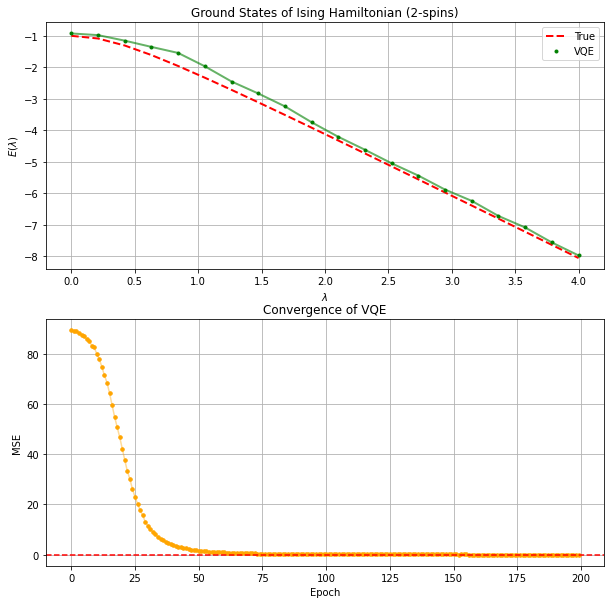

In [6]:
dev = qml.device('default.qubit', wires=N, shots=shots)
E, err = train_vqe_ising(step_size, epochs, lams, N, max_depth, early_stop = 0, circuit = True, plots = True)


## Tests on hyperparameters

### Depth of the circuit (efficientSU2): ```max_depth```

***Parameters:***

step_size = 0.01 (Step size of the optimizer)
epochs    = 200 (Max epochs for each lambda)
N         = 2 (Number of spins of the system)
max_depth = 1 (Depth of the circuit)



***Circuit:***

0: ──RY(0.00)──RZ(0.00)─╭C─┤ ╭<𝓗(0.00,0.00,-1.00)>
1: ──RY(0.00)──RZ(0.00)─╰X─┤ ╰<𝓗(0.00,0.00,-1.00)>


  0%|          | 0/5 [00:00<?, ?it/s]

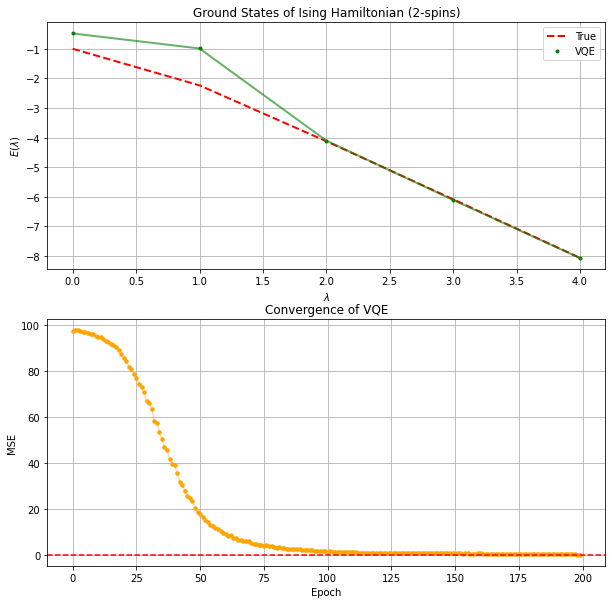

***Parameters:***

step_size = 0.01 (Step size of the optimizer)
epochs    = 200 (Max epochs for each lambda)
N         = 2 (Number of spins of the system)
max_depth = 2 (Depth of the circuit)



***Circuit:***

0: ──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C─┤ ╭<𝓗(0.00,0.00,-1.00)>
1: ──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X─┤ ╰<𝓗(0.00,0.00,-1.00)>


  0%|          | 0/5 [00:00<?, ?it/s]

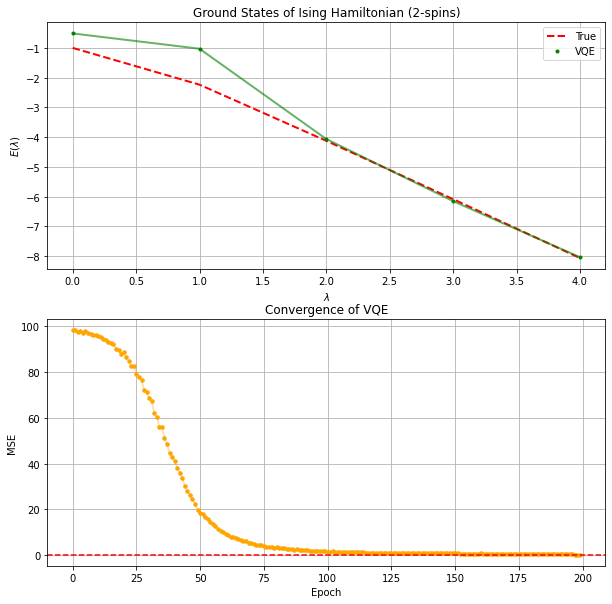

***Parameters:***

step_size = 0.01 (Step size of the optimizer)
epochs    = 200 (Max epochs for each lambda)
N         = 2 (Number of spins of the system)
max_depth = 3 (Depth of the circuit)



***Circuit:***

0: ──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C─┤ ╭<𝓗(0.00,0.00,-1.00)>
1: ──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X─┤ ╰<𝓗(0.00,0.00,-1.00)>


  0%|          | 0/5 [00:00<?, ?it/s]

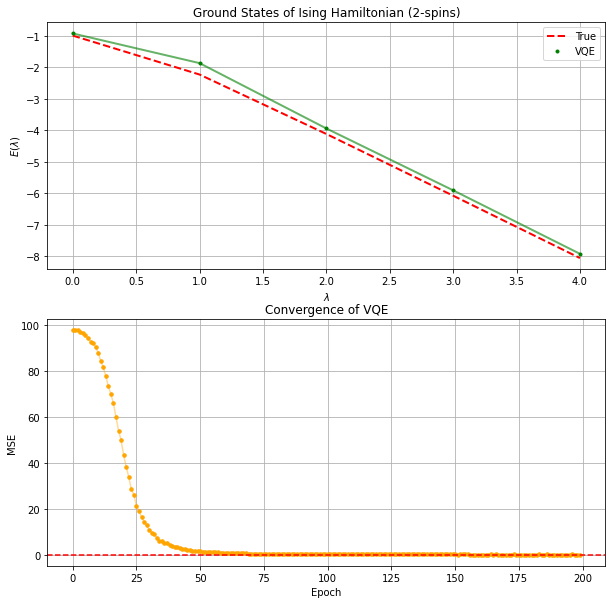

***Parameters:***

step_size = 0.01 (Step size of the optimizer)
epochs    = 200 (Max epochs for each lambda)
N         = 2 (Number of spins of the system)
max_depth = 4 (Depth of the circuit)



***Circuit:***

0: ──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C─┤
1: ──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X─┤

  ╭<𝓗(0.00,0.00,-1.00)>
  ╰<𝓗(0.00,0.00,-1.00)>


  0%|          | 0/5 [00:00<?, ?it/s]

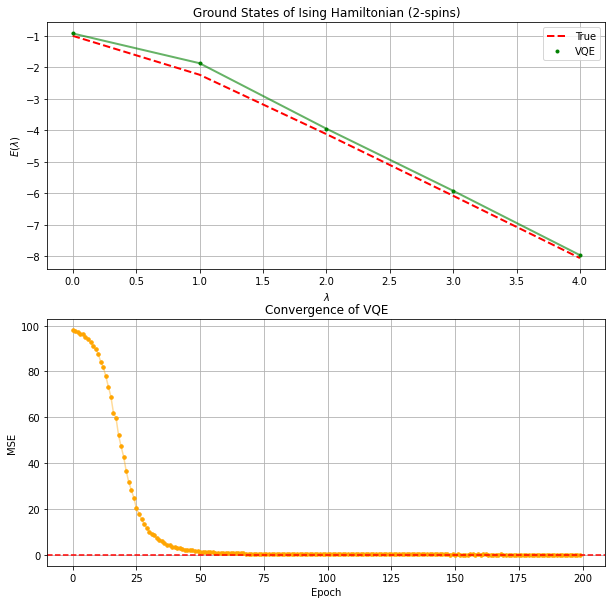

***Parameters:***

step_size = 0.01 (Step size of the optimizer)
epochs    = 200 (Max epochs for each lambda)
N         = 2 (Number of spins of the system)
max_depth = 5 (Depth of the circuit)



***Circuit:***

0: ──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C
1: ──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X

───RY(0.00)──RZ(0.00)─╭C─┤ ╭<𝓗(0.00,0.00,-1.00)>
───RY(0.00)──RZ(0.00)─╰X─┤ ╰<𝓗(0.00,0.00,-1.00)>


  0%|          | 0/5 [00:00<?, ?it/s]

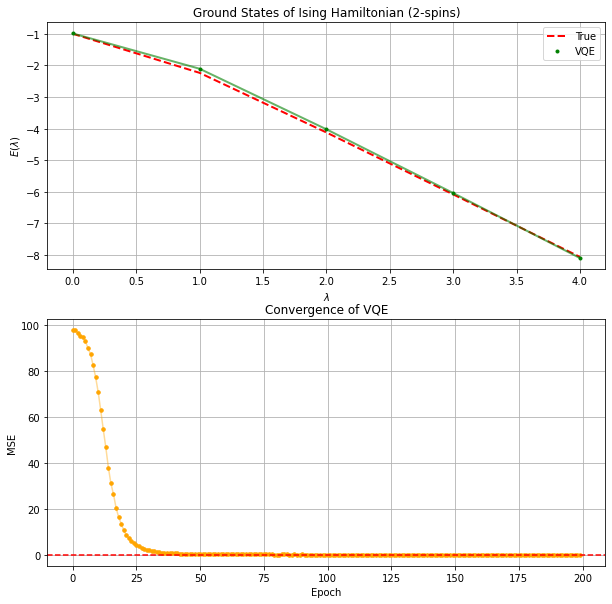

***Parameters:***

step_size = 0.01 (Step size of the optimizer)
epochs    = 200 (Max epochs for each lambda)
N         = 2 (Number of spins of the system)
max_depth = 6 (Depth of the circuit)



***Circuit:***

0: ──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C
1: ──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X

───RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C─┤ ╭<𝓗(0.00,0.00,-1.00)>
───RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X─┤ ╰<𝓗(0.00,0.00,-1.00)>


  0%|          | 0/5 [00:00<?, ?it/s]

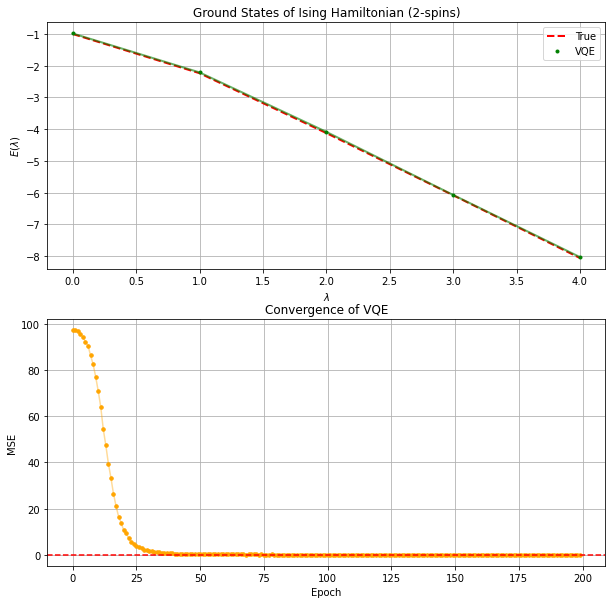

In [7]:
# Just 5 lambdas for quicker computations lams = [0,1,2,3,4]
lams = np.linspace(0,4,5) # Intensities of magnetic field

max_depths = [1,2,3,4,5,6]

for max_depth in max_depths:
    train_vqe_ising(step_size, epochs, lams, N, max_depth, early_stop = 0, circuit = True, plots = True)
    

### Number of spins: ```N```

***Parameters:***

step_size = 0.01 (Step size of the optimizer)
epochs    = 200 (Max epochs for each lambda)
N         = 2 (Number of spins of the system)
max_depth = 3 (Depth of the circuit)



***Circuit:***

0: ──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C──RY(0.00)──RZ(0.00)─╭C─┤ ╭<𝓗(0.00,0.00,-1.00)>
1: ──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X──RY(0.00)──RZ(0.00)─╰X─┤ ╰<𝓗(0.00,0.00,-1.00)>


  0%|          | 0/5 [00:00<?, ?it/s]

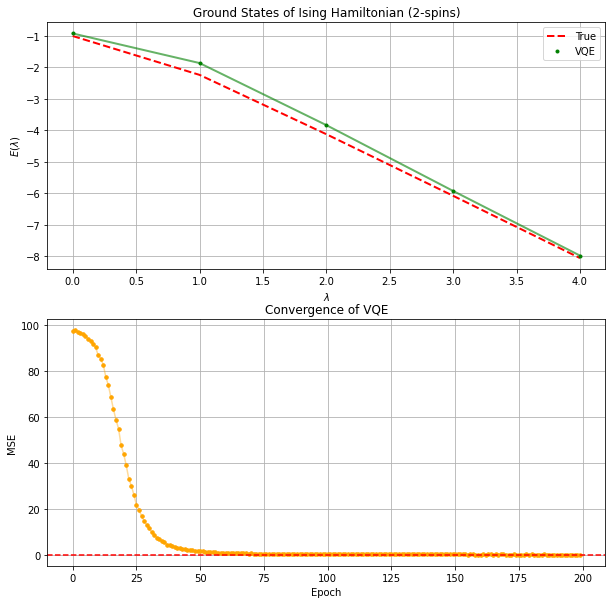

***Parameters:***

step_size = 0.01 (Step size of the optimizer)
epochs    = 200 (Max epochs for each lambda)
N         = 3 (Number of spins of the system)
max_depth = 3 (Depth of the circuit)



***Circuit:***

0: ──RY(0.00)──RZ(0.00)─╭C─╭C──RY(0.00)──RZ(0.00)───────────╭C─╭C──RY(0.00)──RZ(0.00)───────────╭C
1: ──RY(0.00)──RZ(0.00)─╰X─│──╭C─────────RY(0.00)──RZ(0.00)─╰X─│──╭C─────────RY(0.00)──RZ(0.00)─╰X
2: ──RY(0.00)──RZ(0.00)────╰X─╰X─────────RY(0.00)──RZ(0.00)────╰X─╰X─────────RY(0.00)──RZ(0.00)───

──╭C────┤ ╭<𝓗>
──│──╭C─┤ ├<𝓗>
──╰X─╰X─┤ ╰<𝓗>


  0%|          | 0/5 [00:00<?, ?it/s]

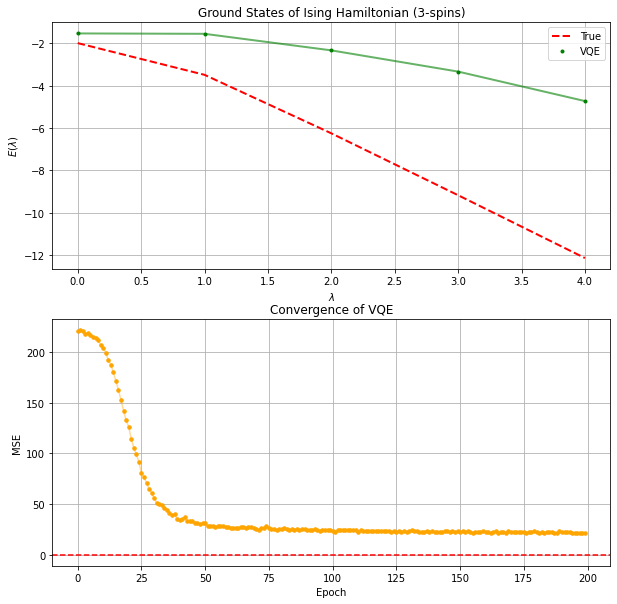

***Parameters:***

step_size = 0.01 (Step size of the optimizer)
epochs    = 200 (Max epochs for each lambda)
N         = 4 (Number of spins of the system)
max_depth = 3 (Depth of the circuit)



***Circuit:***

0: ──RY(0.00)──RZ(0.00)─╭C─╭C─╭C──RY(0.00)──RZ(0.00)─────────────────────╭C────────╭C─╭C──RY(0.00)
1: ──RY(0.00)──RZ(0.00)─╰X─│──│──╭C────────╭C─────────RY(0.00)──RZ(0.00)─╰X────────│──│──╭C───────
2: ──RY(0.00)──RZ(0.00)────╰X─│──╰X────────│─────────╭C─────────RY(0.00)──RZ(0.00)─╰X─│──╰X───────
3: ──RY(0.00)──RZ(0.00)───────╰X───────────╰X────────╰X─────────RY(0.00)──RZ(0.00)────╰X──────────

───RZ(0.00)─────────────────────╭C────────╭C─╭C──────────┤ ╭<𝓗>
──╭C─────────RY(0.00)──RZ(0.00)─╰X────────│──│──╭C─╭C────┤ ├<𝓗>
──│─────────╭C─────────RY(0.00)──RZ(0.00)─╰X─│──╰X─│──╭C─┤ ├<𝓗>
──╰X────────╰X─────────RY(0.00)──RZ(0.00)────╰X────╰X─╰X─┤ ╰<𝓗>


  0%|          | 0/5 [00:00<?, ?it/s]

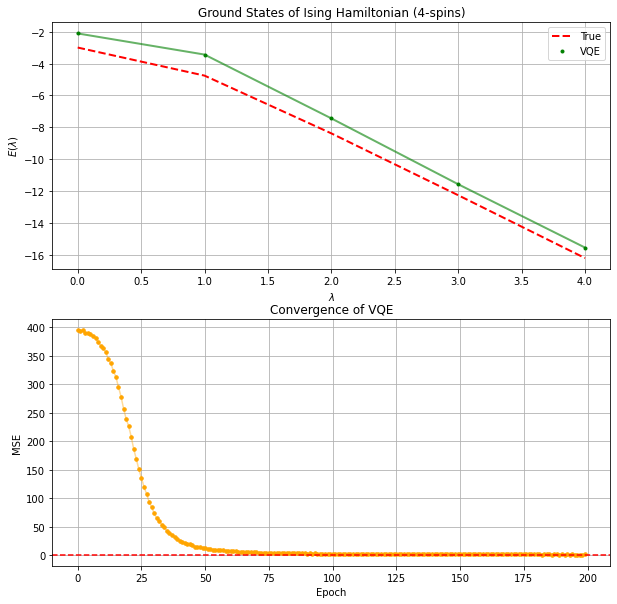

***Parameters:***

step_size = 0.01 (Step size of the optimizer)
epochs    = 200 (Max epochs for each lambda)
N         = 5 (Number of spins of the system)
max_depth = 3 (Depth of the circuit)



***Circuit:***

0: ──RY(0.00)──RZ(0.00)─╭C─╭C─╭C─╭C──RY(0.00)──RZ(0.00)────────────────────────╭C─────────────────
1: ──RY(0.00)──RZ(0.00)─╰X─│──│──│──╭C────────╭C────────╭C──RY(0.00)──RZ(0.00)─╰X─────────────────
2: ──RY(0.00)──RZ(0.00)────╰X─│──│──╰X────────│─────────│──╭C────────╭C─────────RY(0.00)──RZ(0.00)
3: ──RY(0.00)──RZ(0.00)───────╰X─│────────────╰X────────│──╰X────────│─────────╭C─────────RY(0.00)
4: ──RY(0.00)──RZ(0.00)──────────╰X─────────────────────╰X───────────╰X────────╰X─────────RY(0.00)

──╭C────────╭C─╭C──RY(0.00)──RZ(0.00)────────────────────────╭C──────────────────╭C────────╭C─╭C───
──│─────────│──│──╭C────────╭C────────╭C──RY(0.00)──RZ(0.00)─╰X──────────────────│─────────│──│──╭C
──╰X────────│──│──╰X────────│─────────│──╭C────────╭C─────────RY(0.00)──RZ(0.00)─╰X────────│──│──╰X
───RZ(0.00)─╰X─│────────────╰X────────│──╰X────────│─────────╭C─────────RY(0.00)──RZ(0.00)─╰X─│────
───RZ(0.00)────╰X─────────────────────╰X───────────╰X────────╰X─────────RY(0.00)──RZ(0.00)────╰X───

───

  0%|          | 0/5 [00:00<?, ?it/s]

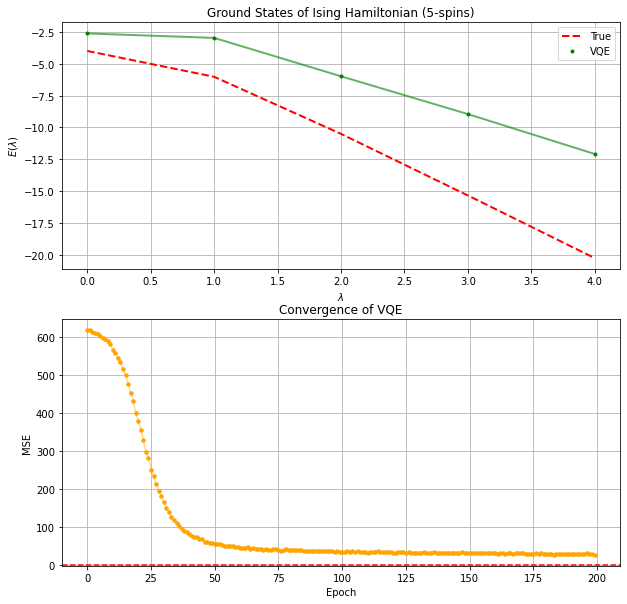

In [8]:
# Just 5 lambdas for quicker computations lams = [0,1,2,3,4]
lams = np.linspace(0,4,5) # Intensities of magnetic field
max_depth = 3
Ns = [2,3,4,5]

for N in Ns:
    dev = qml.device('default.qubit', wires=N, shots=shots)
    train_vqe_ising(step_size, epochs, lams, N, max_depth, early_stop = 0, circuit = True, plots = True)
    

### Simple circuit:

In [9]:
def train_vqe_ising_simple(step_size, epochs, lams, N):
    @qml.qnode(dev_simple)
    def cost_fn_simple(param):
        for spin in range(N):
            qml.RY(param[spin], wires = spin)
        return qml.expval(H)

    vqe_e_simple = []
    errs_simple  = np.zeros((epochs, len(lams)) )

    # Display the circuit
    display(Markdown('***Circuit:***'))

    H = qml_build_H(N, 0)        
    drawer = qml.draw(cost_fn_simple)
    print(drawer(np.array([0]*(N))))

    for i, l in enumerate(tqdm(lams)):
        thetas = np.array([0]*(2*N), requires_grad = True) # Prepare initial state
        opt = qml.GradientDescentOptimizer(stepsize=step_size)

        H = qml_build_H(N, float(l))
        # Compute GS-energy by taking the lowest Eigenvalue from the known matrix
        GS_H = qml_compute_gs(H)

        for epoch in range(epochs):
            # Compute <H>, then update thetas
            thetas, prev_energy = opt.step_and_cost(cost_fn_simple, thetas)
            # Store the MSE of the current (epoch, lambda)-pair
            errs_simple[epoch, i] = (prev_energy - GS_H)**2

            prev_prev_energy = prev_energy

        vqe_e_simple.append(cost_fn_simple(thetas))

    fig, ax = plt.subplots(2, 1, figsize=(10,10))

    true_e = []
    for l in lams:
        H = qml_build_H(N, float(l))
        true_e.append(qml_compute_gs(H))
        
    ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
    ax[0].plot(lams, vqe_e_simple, '.', label='VQE', color='green', lw = 2)
    ax[0].plot(lams, vqe_e_simple, color='green', lw = 2, alpha=0.6)
    ax[0].grid(True)
    ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins)'.format(N))
    ax[0].set_xlabel(r'$\lambda$')
    ax[0].set_ylabel(r'$E(\lambda)$')
    ax[0].legend()

    ax[1].plot(range(epochs), np.mean(errs_simple, axis=1), '.', color='green', ms = 7 )
    ax[1].plot(range(epochs), np.mean(errs_simple, axis=1), color='green', alpha=0.4)
    ax[1].set_title('Convergence of VQE')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('MSE')
    ax[1].grid(True)
    ax[1].axhline(y=0, color='r', linestyle='--')
    
    plt.show()

***Circuit:***

0: ──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)─┤ ├<𝓗>
4: ──RY(0.00)─┤ ╰<𝓗>


  0%|          | 0/10 [00:00<?, ?it/s]

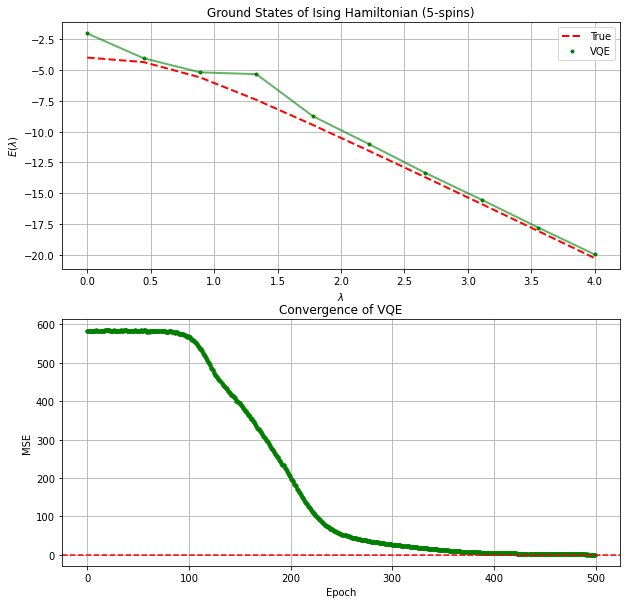

In [10]:
# System parameters:
N = 5                     # number of particles
lams = np.linspace(0,4,10) # Intensities of magnetic field
shots = 1000 

epochs = 500   # Number of epochs
step_size = .01

dev_simple = qml.device('default.qubit', wires=N, shots=shots)

train_vqe_ising_simple(step_size, epochs, lams, N)

***Circuit:***

0: ──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)─┤ ├<𝓗>
4: ──RY(0.00)─┤ ├<𝓗>
5: ──RY(0.00)─┤ ├<𝓗>
6: ──RY(0.00)─┤ ├<𝓗>
7: ──RY(0.00)─┤ ├<𝓗>
8: ──RY(0.00)─┤ ├<𝓗>
9: ──RY(0.00)─┤ ╰<𝓗>


  0%|          | 0/10 [00:00<?, ?it/s]

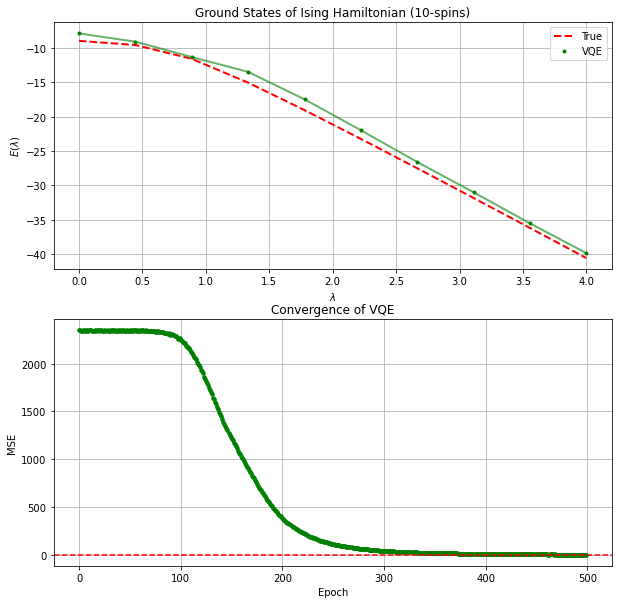

In [11]:
# System parameters:
N = 10                     # number of particles
lams = np.linspace(0,4,10) # Intensities of magnetic field
shots = 1000 

epochs = 500   # Number of epochs
step_size = .01

dev_simple = qml.device('default.qubit', wires=N, shots=shots)

train_vqe_ising_simple(step_size, epochs, lams, N)

In [12]:
def train_vqe_ising_simple_ent(step_size, epochs, lams, N):
    @qml.qnode(dev_simple)
    def cost_fn_simple(param):
        for spin in range(N):
            qml.RY(param[spin], wires = spin)
        for spin in range(N-1):
            qml.CNOT(wires = [spin, spin + 1])
        for spin in range(N):
            qml.RY(param[spin], wires = spin)
            qml.RZ(param[spin], wires = spin)
            
        return qml.expval(H)

    vqe_e_simple = []
    errs_simple  = np.zeros((epochs, len(lams)) )

    # Display the circuit
    display(Markdown('***Circuit:***'))

    H = qml_build_H(N, 0)        
    drawer = qml.draw(cost_fn_simple)
    print(drawer(np.array([0]*(N))))

    for i, l in enumerate(tqdm(lams)):
        thetas = np.array([0]*(2*N), requires_grad = True) # Prepare initial state
        opt = qml.GradientDescentOptimizer(stepsize=step_size)

        H = qml_build_H(N, float(l))
        # Compute GS-energy by taking the lowest Eigenvalue from the known matrix
        GS_H = qml_compute_gs(H)

        for epoch in range(epochs):
            # Compute <H>, then update thetas
            thetas, prev_energy = opt.step_and_cost(cost_fn_simple, thetas)
            # Store the MSE of the current (epoch, lambda)-pair
            errs_simple[epoch, i] = (prev_energy - GS_H)**2

            prev_prev_energy = prev_energy

        vqe_e_simple.append(cost_fn_simple(thetas))

    fig, ax = plt.subplots(2, 1, figsize=(10,10))

    true_e = []
    for l in lams:
        H = qml_build_H(N, float(l))
        true_e.append(qml_compute_gs(H))
        
    ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
    ax[0].plot(lams, vqe_e_simple, '.', label='VQE', color='green', lw = 2)
    ax[0].plot(lams, vqe_e_simple, color='green', lw = 2, alpha=0.6)
    ax[0].grid(True)
    ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins)'.format(N))
    ax[0].set_xlabel(r'$\lambda$')
    ax[0].set_ylabel(r'$E(\lambda)$')
    ax[0].legend()

    ax[1].plot(range(epochs), np.mean(errs_simple, axis=1), '.', color='green', ms = 7 )
    ax[1].plot(range(epochs), np.mean(errs_simple, axis=1), color='green', alpha=0.4)
    ax[1].set_title('Convergence of VQE')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('MSE')
    ax[1].grid(True)
    ax[1].axhline(y=0, color='r', linestyle='--')
    
    plt.show()

***Circuit:***

0: ──RY(0.00)─╭C──RY(0.00)──RZ(0.00)───────────────────────────────┤ ╭<𝓗>
1: ──RY(0.00)─╰X─╭C─────────RY(0.00)──RZ(0.00)─────────────────────┤ ├<𝓗>
2: ──RY(0.00)────╰X────────╭C─────────RY(0.00)──RZ(0.00)───────────┤ ├<𝓗>
3: ──RY(0.00)──────────────╰X────────╭C─────────RY(0.00)──RZ(0.00)─┤ ├<𝓗>
4: ──RY(0.00)────────────────────────╰X─────────RY(0.00)──RZ(0.00)─┤ ╰<𝓗>


  0%|          | 0/10 [00:00<?, ?it/s]

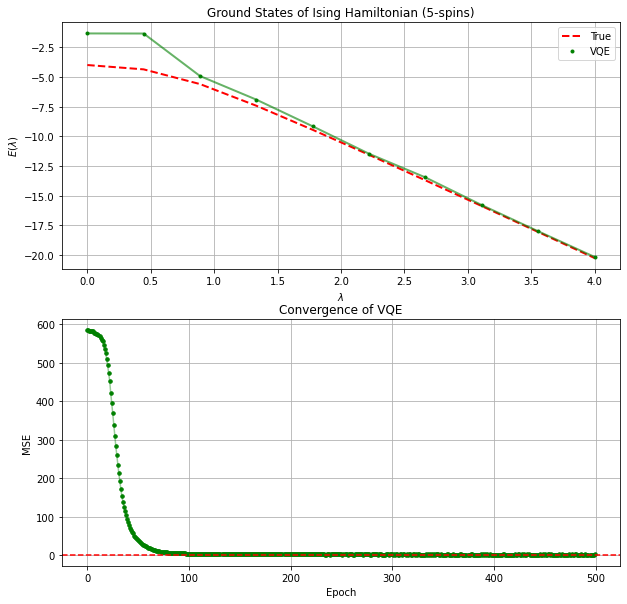

In [13]:
# System parameters:
N = 5                     # number of particles
lams = np.linspace(0,4,10) # Intensities of magnetic field
shots = 1000 

epochs = 500   # Number of epochs
step_size = .01

dev_simple = qml.device('default.qubit', wires=N, shots=shots)

train_vqe_ising_simple_ent(step_size, epochs, lams, N)

### Number of shots: ```qml.device(..., shots)```

***Circuit:***

0: ──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)─┤ ╰<𝓗>


  0%|          | 0/10 [00:00<?, ?it/s]

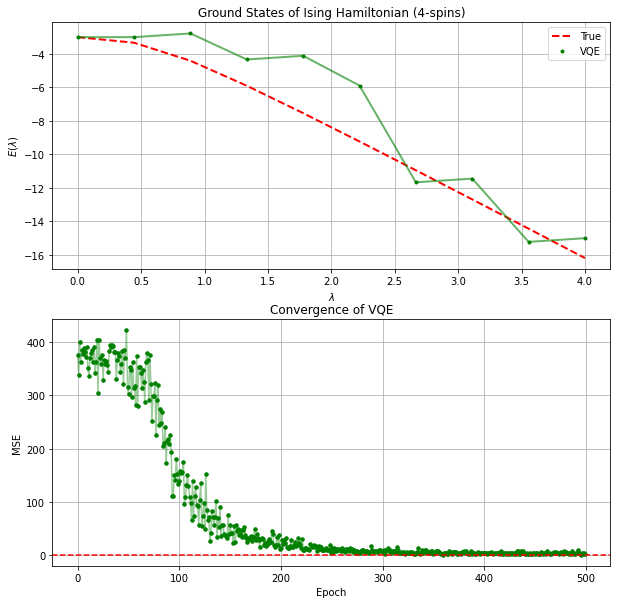

***Circuit:***

0: ──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)─┤ ╰<𝓗>


  0%|          | 0/10 [00:00<?, ?it/s]

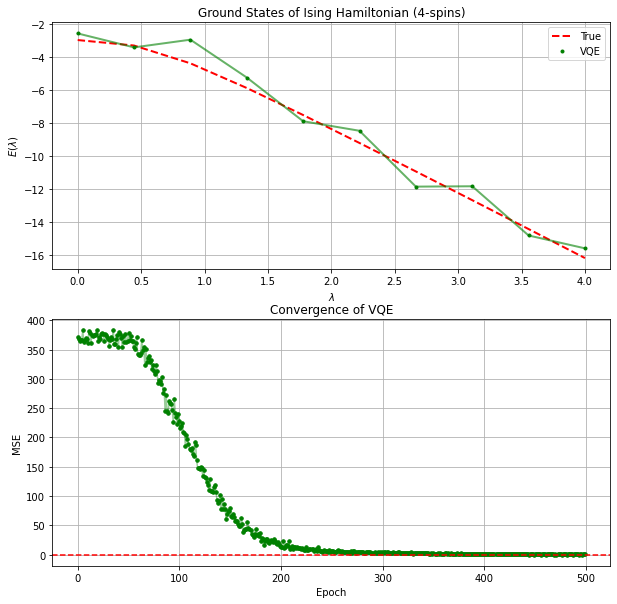

***Circuit:***

0: ──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)─┤ ╰<𝓗>


  0%|          | 0/10 [00:00<?, ?it/s]

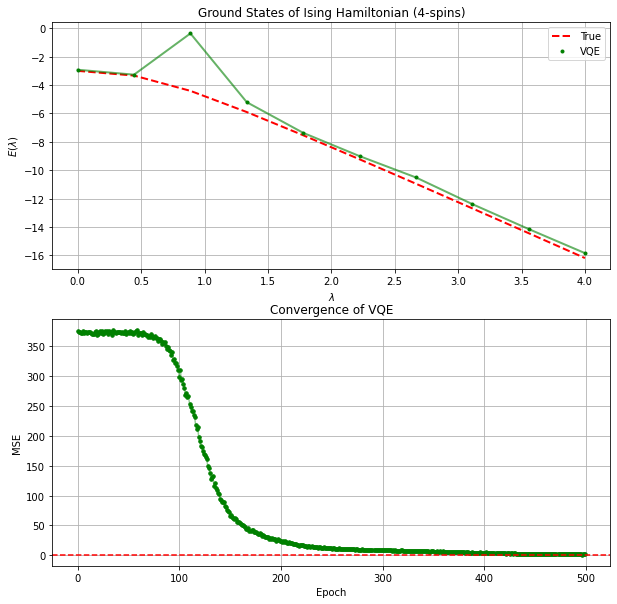

***Circuit:***

0: ──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)─┤ ╰<𝓗>


  0%|          | 0/10 [00:00<?, ?it/s]

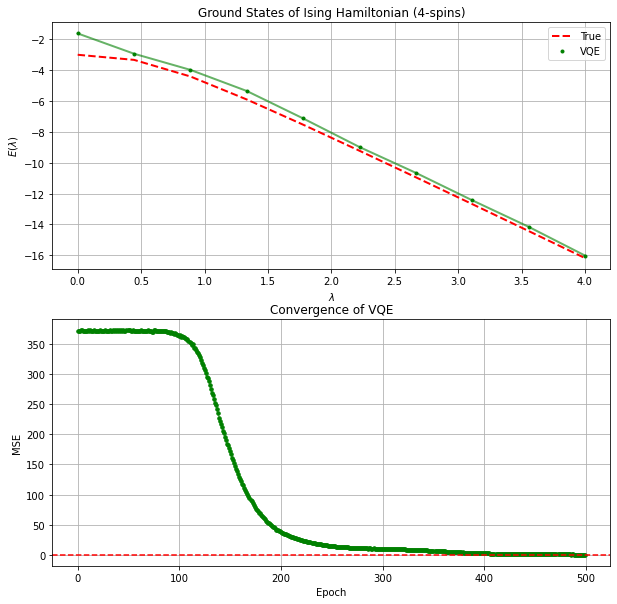

In [14]:
N = 4
shotss = [1,10,100,1000]
lams = np.linspace(0,4,10) # Intensities of magnetic field
step_size = .01
epochs = 500   # Number of epochs

for shots in shotss:
    dev_simple = qml.device('default.qubit', wires=N, shots=shots)
    train_vqe_ising_simple(step_size, epochs, lams, N)
    

---
## Back-up code

### Finding the excited states of H

Minimize:

$$COST(k, \vec{\theta}) = H(\vec{\theta}) + \beta \sum_{i = 1}^{k-1} |\psi_i><\psi_{i}|$$

source: [Variational Quantum Computation of Excited States](https://arxiv.org/pdf/1805.08138.pdf)

### EfficientSU2:
![img](https://qiskit.org/textbook/images/ch-applications/vqe-molecules_12_3.png)

source: [Qiskit documentation](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html)

---
## Resources
* [Pennylane VQE Tutorial](https://pennylane.ai/qml/demos/tutorial_vqe.html)